# Algorithm 4

In [1]:
from trajectory_generator import *
import numpy as np
import matplotlib.pyplot as plt
from cmap import Colormap
from scipy.special import comb
from scipy import integrate
from scipy import special
from itertools import combinations_with_replacement
from collections import Counter
from functions import *

## Trajectories

(10000, 2, 3)


(-2.1826656699648104,
 1.8359790692610152,
 -1.1962932056564266,
 2.74825329576769)

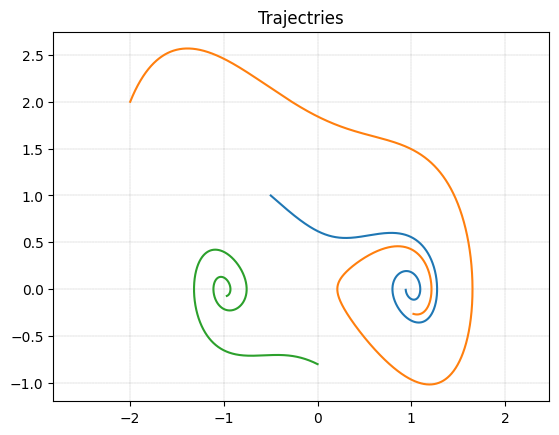

In [2]:
# mu=1; model = VanderPol(mu); d=2 # Van der Pol oscillator
alpha=-1; beta=1; delta=0.5; model=Duffing(alpha,beta,delta); d=2 # Duffing oscillator


# Trajectries of the dynamical system
ax=plt.figure().add_subplot()
x0 = np.array([[-0.5,1],[-2,2],[0,-0.8]]).T #initial points
traj = model.generate_trajectory(x0, t=10, h=1e-3)
print(traj.shape)
ax.grid(True, linestyle='--', color='k', linewidth=0.1)
ax.set_title("Trajectries")
ax.plot(traj[:,0,:], traj[:,1,:])
ax.axis("equal")

## Computation of the eigenvalues of the extended generator of the Koopman operator

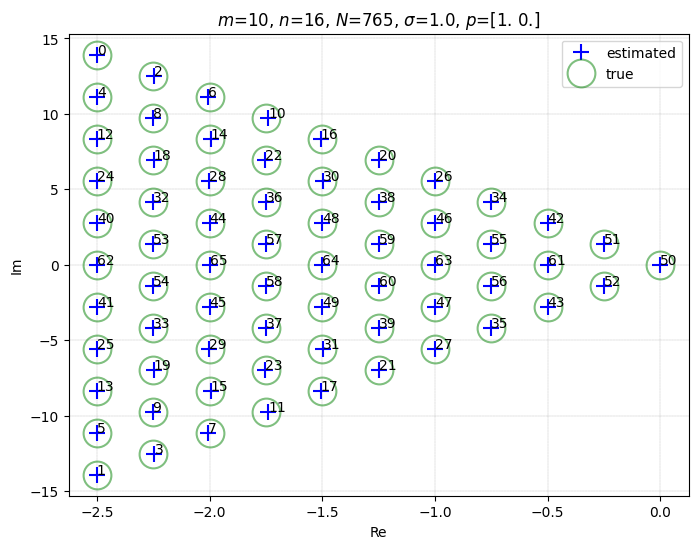

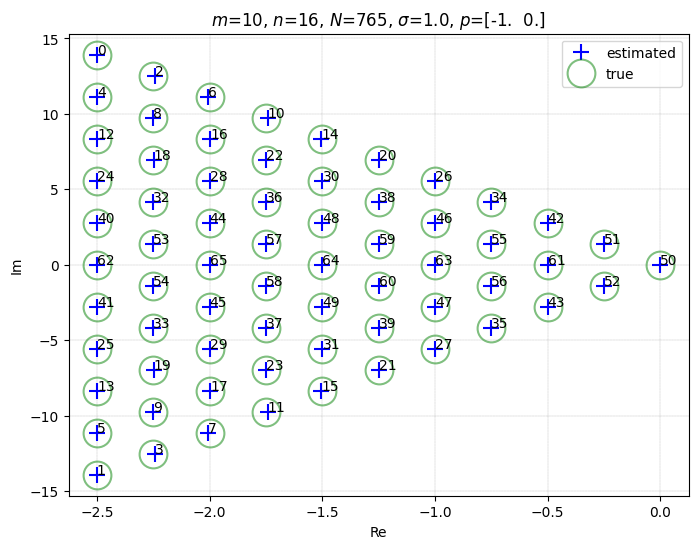

In [3]:

m = 10
n = 16
rm = comb(m+d,d, exact = True) # dimension of V_{p,m}
rn = comb(n+d,d, exact = True) # dimension of V_{p,n}
N = 5*rn # number of sample

# Data
## Uniformly random sapmling from [-1,1]^2
X = 2*np.random.rand(d,N) - 1 

## exact velocities at X
Y = model.vector_field(X)


# Computation of V_n^X and W_m^{X,Y}
constV = constV_exp
constW = constW_exp
sigma_kernel = 1.0 #sigma
ps = np.array([[1,0],[-1,0]], dtype = float).T #fixed points for computation
# ps = np.array([[0,0]], dtype = float).T #fixed point for computation
r_ps = ps.shape[1] #number of the fixed points
b = np.zeros((d,1)) #shift parameter of the exponential kernel 
Vs = np.zeros((r_ps,rn,N))
Ws = np.zeros((r_ps,rm,N))
for i in range(r_ps):
    Vs[i] = constV(X, ps[:,[i]], n, sigma_kernel, b) # V_n^X
    Ws[i] = constW(X, Y, ps[:,[i]], m, sigma_kernel, b) # W_m^{X,Y}

#Computation of A
As = (Ws@(np.linalg.pinv(Vs)))[...,:rm] #exponential kernel
# Computation of eigenvalues and eigenvectors
# evals_PF, e_vecs_PF = np.linalg.eig(As)
evals_Ko, evecs_Ko = np.linalg.eig(As.transpose(0,2,1))



for i in range(r_ps):
    # Jacobian matrix of the dynamical system at 0
    dFp=model.jacmat(ps[:,[i]])
    
    # eigenvalues of the Jacobian matrix of the vector field at 0
    eval_dFp=np.linalg.eig(dFp)[0][0] 
    
    # make the array of multiplications of eigenvalues
    evals_true =np.array([np.sum(ell, axis=0) for ell in combinations_with_replacement([0 + 0j] + list(eval_dFp),m)]) 

    # figures
    ax=plt.figure(figsize=(8,6)).add_subplot()
    ax.set_title(f'$m$={m}, $n$={n}, $N$={N}, $\sigma$={sigma_kernel}, $p$={ps[:,i]}')
    ax.grid(True, linestyle='--', color='k', linewidth=0.1)
    ax.plot(evals_Ko[i].real, evals_Ko[i].imag, '+', c='blue', markersize=12, markeredgewidth=1.5, label='estimated')
    ax.plot(evals_true.real, evals_true.imag, 'go', alpha=0.5, markerfacecolor='none', markersize=20, markeredgewidth=1.5, label='true')
    ax.set_xlabel('Re')
    ax.set_ylabel('Im')
    # ax.set_xlim(0.7,0.8)
    ax.legend()
    # add the indices of estimated eigenvalues (to specify eval_idx)
    for j, txt in enumerate(range(rm)):
        ax.annotate(txt, (evals_Ko[i].real[j], evals_Ko[i].imag[j]))
    plt.show()

## Heat maps of eigenfunctions

### Construction of eigenfunctions

In [4]:
Gs=make_Gs(m,ps,sigma_kernel,deg=20)
Gs_diag=np.zeros((r_ps,rm, r_ps,rm))
for i in range(r_ps):
    Gs_diag[i,[i for i in range(rm)],i,[i for i in range(rm)]] = Gs[i,[i for i in range(rm)],i,[i for i in range(rm)]]

# Computation of H_ij's
Hs = np.linalg.pinv(Gs.reshape(r_ps*rm,r_ps*rm), hermitian=True)@Gs_diag.reshape(r_ps*rm,r_ps*rm)

def eigenfunction(x, eval_idx, ps_idx): #eval_idx = index of eigenvalues, ps_idx = index of the fixed points
    efunc = np.zeros(x.shape[1:], dtype=complex)
    for i in range(r_ps):
        efunc += (constV(x,ps[:,[i]],m,sigma_kernel,b).T@Hs[i*rm:(i+1)*rm,ps_idx*rm:(ps_idx+1)*rm]@evecs_Ko[ps_idx,:,eval_idx]).T
    return efunc

mesh=100 # number of mesh
area= 2 # range of the heat map

x,y=np.meshgrid(*[np.linspace(-area,area,mesh)]*2)
xy =np.array([np.ravel(x),np.ravel(y)])

ef0 = eigenfunction(xy, eval_idx=61, ps_idx=0)
ef1 = eigenfunction(xy, eval_idx=61, ps_idx=1)
ef = ef0 - ef1

# ef = eigenfunction(xy, eval_idx=2, ps_idx=0)

### Heat maps of absolute values

(-2.0, 2.0)

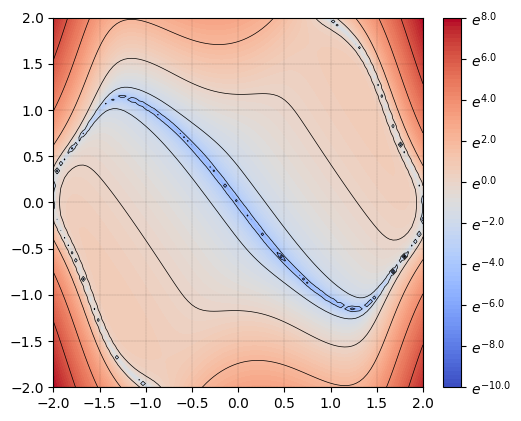

In [5]:
fig, ax=plt.subplots()
z_abs=np.log(1e-14+np.abs(ef)).reshape(mesh, mesh)
CS = ax.contourf(x, y, z_abs, 100, cmap=Colormap('coolwarm').to_mpl())
CS_level = ax.contour(CS, levels=CS.levels[::10], colors='k', linewidths=0.5, linestyles='solid') 
cbar=fig.colorbar(CS, fraction=0.0458, pad=0.04) #magical parameter to fit color bar 
cbar.set_ticklabels([f'$e^{{{x:.1f}}}$' for x in CS.levels])
ax.grid(True, linestyle='--', color='k', linewidth=0.1)
ax.set_aspect('equal', 'box')
ax.set_xlim(-area,area)
ax.set_ylim(-area,area)

### Heat map of argument

(-2.0, 2.0)

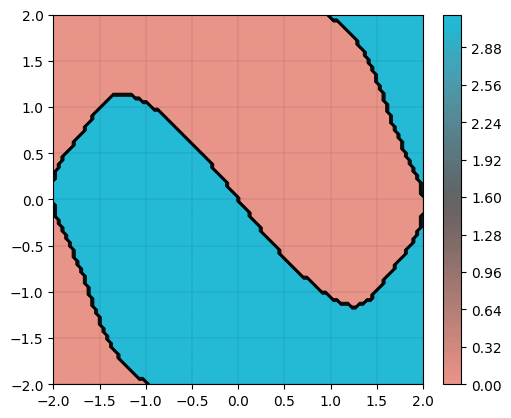

In [6]:
fig, ax=plt.subplots()
z_arg=np.angle(ef).reshape(mesh, mesh)
CS = ax.contourf(x, y, z_arg, 100, cmap=Colormap('cet_cbtc1').to_mpl(),vmin=-np.pi, vmax=np.pi)
CS_level = ax.contour(CS, levels=CS.levels[::10], colors='k', linewidths=0.5, linestyles='solid') 
cbar=fig.colorbar(CS, fraction=0.0458, pad=0.04) #magical parameter to fit color bar 
ax.grid(True, linestyle='--', color='k', linewidth=0.1)
ax.set_aspect('equal', 'box')
ax.set_xlim(-area,area)
ax.set_ylim(-area,area)